### Dataset Creation

This is the notebook to train the classification of Diabetic Retinography with CNNs

This notebook contains the following
1. Dataset Creation and Augmentation
2. Train and Eval Functions
3. CNN Class Models (InceptionV3, ResNet50, ResNet152, EfficientNet, DenseNet, VGG16, MaxViT)

This notebook assumes the following project structure:
```bash
Root
├── notebooks
│   └── notebook1.ipynb
└── input
    └── Data
        ├── DDR
        │   ├── Train
        │   └── Test
        ── BEN
        │   ├── Train
        │   └── Test
        ├── CLAHE
        │   ├── Train
        │   └── Test
        ├── UNET_Binary
        │   ├── Train
        │   └── Test
        └── UNET_Multiclass
            ├── Train
            └── Test
```

If you do not have the dataset, please download it from our Google Drive

In [1]:
#Necessary Imports
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

### Dataset Creation

In [2]:
# Parameter required
image_size = (299,299)
batch_size = 64

# Defining Train Transforms
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally with a 50% probability
    transforms.RandomVerticalFlip(p=0.5),  # Flip vertically with a 50% probability
    transforms.RandomAffine(
        degrees=360,  # Rotation
        translate=(0.1, 0.1),  # Translation
        scale=(0.8, 1.2) #Zooming
    ),
    transforms.ToTensor()
])


# Defining Evaluation Transforms, no data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

#### Ben Graham dataset

In [3]:
# Create PyTorch datasets for training and validation
ben_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/train', 
                    transform=train_transform
                    )
ben_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/val', 
                    transform=eval_transform
                    )
ben_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
ben_train_dataloader = torch.utils.data.DataLoader(
                    ben_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
ben_val_dataloader = torch.utils.data.DataLoader(
                    ben_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
ben_test_dataloader = torch.utils.data.DataLoader(
                    ben_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### CLAHE dataset

In [ ]:
# Create PyTorch datasets for training and validation
clahe_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/train', 
                    transform=train_transform
                    )
clahe_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/val', 
                    transform=eval_transform
                    )
clahe_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
clahe_train_dataloader = torch.utils.data.DataLoader(
                    clahe_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
clahe_val_dataloader = torch.utils.data.DataLoader(
                    clahe_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
clahe_test_dataloader = torch.utils.data.DataLoader(
                    clahe_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### UNET_Binary Dataset

In [ ]:
# Create PyTorch datasets for training and validation
unetb_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/train', 
                    transform=train_transform
                    )
unetb_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/val', 
                    transform=eval_transform
                    )
unetb_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
unetb_train_dataloader = torch.utils.data.DataLoader(
                    unetb_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetb_val_dataloader = torch.utils.data.DataLoader(
                    unetb_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetb_test_dataloader = torch.utils.data.DataLoader(
                    unetb_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### UNET_Multiclass Dataset

In [ ]:
# Create PyTorch datasets for training and validation
unetm_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/train', 
                    transform=train_transform
                    )
unetm_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/val', 
                    transform=eval_transform
                    )
unetm_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
unetm_train_dataloader = torch.utils.data.DataLoader(
                    unetm_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetm_val_dataloader = torch.utils.data.DataLoader(
                    unetm_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetm_test_dataloader = torch.utils.data.DataLoader(
                    unetm_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### Visualisation

In [ ]:
def visualise_img(dataloader, class_list: list):
    """
    Function to visualize the first 9 images of the dataset.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object containing the dataset to visualize.
        class_list (list): List of class labels.
    """
    #Get the first batch of images and labels
    train_images, train_labels = next(iter(dataloader))
    batch_size = train_images.size(0)  # Get the batch size

    #Print the shape of the batch
    print(f"Images batch shape: {train_images.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    #Create a 3x3 grid for visualization
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        for j in range(3):
            #Get the index of the image in the batch
            index = i * 3 + j

            if index < batch_size:
                #Prepare image to print
                img = train_images[index].squeeze().numpy().transpose((1, 2, 0))
                label = train_labels[index].item()

                #Plot the image
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Label: {label}, {class_list[label]}', loc='left')

    plt.tight_layout()
    plt.show()

In [ ]:
visualise_img(ben_train_dataloader, ben_train_dataset.classes)

In [ ]:
visualise_img(clahe_train_dataloader, clahe_train_dataset.classes)

In [ ]:
visualise_img(unetb_train_dataloader, unetb_train_dataset.classes)

In [ ]:
visualise_img(unetm_train_dataloader, unetm_train_dataset.classes)

### Train, Eval Functions

In [4]:
def calculate_dr_class_weights(dataset):
    """
    Function to calculate class weights
    Class Weights of i = Total Num of Samples / Total Num of samples of Class i * Num of classes

    We calculate the average of samples per class if it was equally distributed and then calculate the class weights based on the difference of actual vs ideal

    Args:
        dataset: train dataset

    Returns:
        weights (np.ndarray): array of size n_classes with the weights of each class in each index
    """
    # Counting the number of samples in each class
    class_counts = np.bincount(dataset.targets)
    total_samples = sum(class_counts)
    num_classes = len(class_counts)
    
    # Calculating class weights inversely proportional to the number of samples in each class
    weights = total_samples / (num_classes * class_counts)

    print("Class Weights:", weights)
    
    return weights

In [5]:
import torch

def eval(model, 
         criterion, 
         img_size:tuple,
         val_dataloader, 
         device='cuda'):
    """
    Evaluation function for finetuning CNN models with a model object,
    incorporating average sensitivity for a multiclass problem.

    Sensitivity function: True Positives / (True Positives + False Negatives)

    Args:
        model: model to be trained
        criterion: loss function
        img_size (tuple): image size of dataset for model. All inputs will be resized to image size
        val_dataloader: val / test dataloader
        device (str, optional): 'cpu' or 'cuda', defaults to cuda.

    Returns:
        val_loss: float of the average val loss.
        val_accuracy: float of the accuracy.
        val_sensitivity: float of the average sensitivity across all classes.
    """

    model = model.to(device)
    
    #set model to eval mode
    model.eval()

    #variables 
    val_loss = 0.0
    correct = 0
    total = 0
    n_classes = 5
    true_positives = [0] * n_classes #stores num of true positives per class
    actual_positives = [0] * n_classes #stores total number of positives per class
    total_sensitivity = 0

    with torch.no_grad():
        for image, label in val_dataloader:
            batch_sensitivity = 0

            #resize image with bilinear, same as torchvision.transforms.Resize()
            image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') 
            image, label = image.to(device), label.to(device)

            outputs = model(image)  #predict label
            loss = criterion(outputs, label)  #calculate loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1) #get prediction
            total += label.size(0)
            correct += (predicted == label).sum().item()

            for i in range(n_classes):
                true_positives[i] += ((predicted == i) & (label == i)).sum().item() #true positives
                actual_positives[i] += (label == i).sum().item() #true positives + false negatives
            
                if (label == i).sum().item() > 0:
                    batch_sensitivity += true_positives[i] / actual_positives[i]

                else:
                    pass
            
            total_sensitivity += batch_sensitivity/n_classes #average sensitivity for batch

    # Calculate accuracy, avg loss, and avg sensitivity
    accuracy = (correct / total) * 100
    avg_val_loss = val_loss / len(val_dataloader)
    avg_sensitivity = total_sensitivity/len(val_dataloader)
    
    return avg_val_loss, accuracy, avg_sensitivity


In [6]:
def train(model, 
          criterion, 
          optimiser, 
          img_size:tuple,
          train_dataloader, 
          val_dataloader=None, 
          saving_metric:str='sensitivity',
          num_epochs:int=25, 
          device:str='cuda', 
          model_name:str=None):
    """
    Training Function to train model
    Runs validation for each epoch to calculate: Validation Loss, Validation Accuracy, Validation Sensitivity
    Best and last model will be saved to ../models/cnn under {model_name}_best.pt and {model_name}_last.pt
    
    Args:
        model: model to be trained
        criterion: loss function
        optimiser: optimiser chosen
        img_size (tuple): image size of dataset for model. All inputs will be resized to image size
        train_dataloader: train dataloader
        val_dataloader (optional): val dataloader, if None no validation will be calculated. Defaults to None.
        saving_metric (str, optional): saving metrics for best model, either "loss", "accuracy", or "sensitivity". Defaults to 'sensitivity'.
        num_epochs (int, optional): number of training epochs. Defaults to 25.
        device (str, optional): cuda or cpu. Defaults to 'cuda'.
        model_name (str, optional): model name to be saved, if None no model will be saved. Defaults to None.

    Returns:
        results_dataframe: dataframe of [model, train_loss, val_loss, val_accuracy, val_sensitivity] where each row is each epoch
    """

    if saving_metric not in ["loss", "accuracy", "sensitivity"]:
        raise Exception("Invalid saving metrics found, please only use loss, accuracy or sensitivity")

    #initialising results container
    results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])
    
    #placeholders
    val_loss = ''
    val_accuracy = ''
    val_sensitivity = ''


    for epoch in range(num_epochs):

        #initialising training
        model.train()
        training_loss = 0.0

        for image, label in tqdm(train_dataloader):
            
            #resize image with bilinear, same as torchvision.transforms.Resize()
            image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') 
            image, label = image.to(device), label.to(device)

            optimiser.zero_grad()
            outputs = model(image)
            #calculate loss and train model
            loss = criterion(outputs, label)
            loss.backward()
            optimiser.step()
            training_loss += loss.item() #update the training loss

        epoch_loss = training_loss / len(train_dataloader) #calculate training loss in epoch
        print(f"Epoch {epoch+1} completed, training loss: {epoch_loss}")

        #validation
        if val_dataloader is not None:
            model.eval()  #set model to evaluate mode
            val_loss, val_accuracy,  val_sensitivity = eval(model=model, 
                                                               criterion=criterion,
                                                                val_dataloader=val_dataloader, 
                                                                img_size = img_size,
                                                                device=device) 
            
            print(f"Validation loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}, Validation Sensitivty: {val_sensitivity:2f}")
            

            if saving_metric == 'loss' and len(results) > 0 and val_loss < min(results['val loss'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")

            elif saving_metric == 'accuracy' and len(results) > 0 and val_accuracy > max(results['val accuracy'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")

            elif saving_metric == 'sensitivity' and len(results) > 0 and val_sensitivity > max(results['val sensitivity'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")
            
        #updating results
        results.loc[len(results)] = [model_name, epoch_loss, val_loss, val_accuracy, val_sensitivity]


    #save the last model
    if model_name is not None:
        torch.save(model, f'../models/cnn/{model_name}_last.pt')

    return results


### Model

In [7]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_first_unfreeze:int, num_last_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_first_unfreeze (int): Number of first layers to unfreeze and finetune
            num_last_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_last_unfreeze layers
        for param in model_paramteres[-num_last_unfreeze:]:
            param.requires_grad = True

        #unfreeze first num_first_unfreeze layers 
        for param in model_paramteres[:num_first_unfreeze]:
            param.requires_grad = True
            
        #freeze rest of the layers
        for param in model_paramteres[num_first_unfreeze:-num_last_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

### Training all model without weighted class with unfrozen last linear layer

Training all model with Cross Entropy Loss without any class weights on Ben Graham dataset

Note: We have to put 2 as num_last_unfreeze due to the fact that the lineaer layer has bias and weights and is thus considered as 2 layers in the architecture.

In [ ]:
models_list = [['InceptionV3', (299,299)],
               ['Resnet50', (224,224)],
               ['Resnet152',(224,224)],
               ['EfficientNet',(224,224)],
               ['DenseNet',(224,224)],
               ['VGG16',(224,224)],
               ['MaxVit', (224,224)]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for model_name, img_size in models_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels(model_name, 0, 2, len(ben_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training {model_name}------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         img_size,
                         ben_train_dataloader,
                         ben_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"{model_name}_base")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/cnn_base.csv")


In [ ]:
models_list = [['InceptionV3', (299,299)],
               ['Resnet50', (224,224)],
               ['Resnet152',(224,224)],
               ['EfficientNet',(224,224)],
               ['DenseNet',(224,224)],
               ['VGG16',(224,224)],
               ['MaxVit', (224,224)]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name, img_size in models_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/{model_name}_base_best.pt')
    last_model = torch.load(f'../model/cnn/{model_name}_base_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating {model_name}------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

### Training all model with weighted class with unfrozen last linear layer

Training all model with Cross Entropy Loss with calculated class weights on Ben Graham dataset

Class Weights of i = Total Num of Samples / Total Num of samples of Class i * Num of classes

We calculate the average of samples per class if it was equally distributed and then calculate the class weights based on the difference of actual vs ideal

<br/>
Note: We have to put 2 as num_last_unfreeze due to the fact that the lineaer layer has bias and weights and is thus considered as 2 layers in the architecture.

In [ ]:
class_weights = calculate_dr_class_weights(ben_test_dataset)

In [ ]:
models_list = [['InceptionV3', (299,299)],
               ['Resnet50', (224,224)],
               ['Resnet152',(224,224)],
               ['EfficientNet',(224,224)],
               ['DenseNet',(224,224)],
               ['VGG16',(224,224)],
               ['MaxVit', (224,224)]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for model_name, img_size in models_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels(model_name, 0, 2, len(ben_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training {model_name}------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         img_size,
                         ben_train_dataloader,
                         ben_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"{model_name}_weighted")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/cnn_weighted.csv")

In [ ]:
models_list = [['InceptionV3', (299,299)],
               ['Resnet50', (224,224)],
               ['Resnet152',(224,224)],
               ['EfficientNet',(224,224)],
               ['DenseNet',(224,224)],
               ['VGG16',(224,224)],
               ['MaxVit', (224,224)]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name, img_size in models_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/{model_name}_weighted_best.pt')
    last_model = torch.load(f'../models/cnn/{model_name}_weighted_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating {model_name}------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

### Training all model with custom weighted class with unfrozen last linear layer

Training all model with Cross Entropy Loss with custom class weights [1, 6, 1, 10, 3] on Ben Graham dataset


Note: We have to put 2 as num_last_unfreeze due to the fact that the lineaer layer has bias and weights and is thus considered as 2 layers in the architecture.

In [ ]:
models_list = [['InceptionV3', (299,299)],
               ['Resnet50', (224,224)],
               ['Resnet152',(224,224)],
               ['EfficientNet',(224,224)],
               ['DenseNet',(224,224)],
               ['VGG16',(224,224)],
               ['MaxVit', (224,224)]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for model_name, img_size in models_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels(model_name, 0, 2, len(ben_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss(weight=torch.tensor([1, 6, 1, 10, 3], dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training {model_name}------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         img_size,
                         ben_train_dataloader,
                         ben_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"{model_name}_custom_weighted")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/cnn__custom_weighted.csv")


In [ ]:
models_list = [['InceptionV3', (299,299)],
               ['Resnet50', (224,224)],
               ['Resnet152',(224,224)],
               ['EfficientNet',(224,224)],
               ['DenseNet',(224,224)],
               ['VGG16',(224,224)],
               ['MaxVit', (224,224)]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name, img_size in models_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/{model_name}_custom_weighted_best.pt')
    last_model = torch.load(f'../models/cnn/{model_name}_custom_weighted_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating {model_name}------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

### Training all model with calculated weighted class with 8 last unfrozen layers

Training all model with Cross Entropy Loss with calculated class weights on Ben Graham dataset with last 8 children layers unfreezed

This helps us decide which model shall we be focusing on for layer exploration

In [ ]:
class_weights = calculate_dr_class_weights(ben_test_dataset)

In [ ]:
models_list = [['InceptionV3', (299,299)],
               ['Resnet50', (224,224)],
               ['Resnet152',(224,224)],
               ['EfficientNet',(224,224)],
               ['DenseNet',(224,224)],
               ['VGG16',(224,224)],
               ['MaxVit', (224,224)]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for model_name, img_size in models_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels(model_name, 0, 8, len(ben_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training {model_name}------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         img_size,
                         ben_train_dataloader,
                         ben_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"{model_name}_8_weighted")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/cnn_8_weighted.csv")


In [ ]:
models_list = [['InceptionV3', (299,299)],
               ['Resnet50', (224,224)],
               ['Resnet152',(224,224)],
               ['EfficientNet',(224,224)],
               ['DenseNet',(224,224)],
               ['VGG16',(224,224)],
               ['MaxVit', (224,224)]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name, img_size in models_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/{model_name}_8_weighted_best.pt')
    last_model = torch.load(f'../models/cnn/{model_name}_8_weighted_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating {model_name}------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

### DenseNet Layer Exploration

Exploring different numbers of unfrozen layers in DenseNet with Ben's Graham dataset

The layers explored will be
- 0 unfrozen first layer and 1 unfrozen last layer (done earlier)
- 1 unfrozen first layer and 1 unfrozen last layer
- 0 unfrozen first layer and 8 unfrozen last layer (done earlier)
- 1 unfrozen first layer and 8 unfrozen last layer
- 0 unfrozen first layer and 16 unfrozen last layer
- 1 unfrozen first layer and 16 unfrozen last layer

In [8]:
class_weights = calculate_dr_class_weights(ben_train_dataset)

Class Weights: [ 0.40443009  3.8864745   0.55102169 10.37159763  2.78664547]


In [ ]:
layer_list = [[1, 2],
              [1, 8],
              [0, 16],
              [0, 16]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels("DenseNet", num_first_unfreeze, num_last_unfreeze, len(ben_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training DenseNet with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         img_size,
                         ben_train_dataloader,
                         ben_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"DenseNet_{num_first_unfreeze}_{num_last_unfreeze}")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/densenet_layer.csv")


In [ ]:
layer_list = [[1, 2],
              [1, 8],
              [0, 16],
              [0, 16]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_best.pt')
    last_model = torch.load(f'../models/cnn/DenseNet_{num_first_unfreeze}_{num_last_unfreeze}_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating DenseNet with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

### Others

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("results/densenet_layer.csv")
grouped_data = data.groupby('Model')

for model, model_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(model_data.index, model_data['train loss'], label='Train Loss')
    plt.plot(model_data.index, model_data['val loss'], label='Validation Loss')
    plt.plot(model_data.index, model_data['val sensitivity'], label='Validation Sensitivity')
    
    plt.title(f'{model} Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


### Maxvit

In [10]:
all_results.to_csv("results/maxvit_layer_32_1.csv")


In [15]:
layer_list = [#[1, 2],
              #[1, 8],
              #[0, 16],
            #   [1, 16],
            # [0,32],
            [1,32]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels("MaxVit", num_first_unfreeze, num_last_unfreeze, len(ben_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    img_size =(224,224)
    print(f"-------------Training MaxVit with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         img_size,
                         ben_train_dataloader,
                         ben_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"MaxVit_{num_first_unfreeze}_{num_last_unfreeze}")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/maxvit_layer_32.csv")


-------------Training MaxVit with 1 Unfrozen First Layers and 32 Unfrozen Last Layers------------


100%|██████████| 137/137 [01:36<00:00,  1.42it/s]


Epoch 1 completed, training loss: 1.319461669364985
Validation loss: 1.12693257133166, Validation Accuracy: 62.43, Validation Sensitivty: 0.480376


100%|██████████| 137/137 [01:09<00:00,  1.97it/s]


Epoch 2 completed, training loss: 1.1315965852598204
Validation loss: 1.1158240060011546, Validation Accuracy: 47.63, Validation Sensitivty: 0.483911
Best model saved


100%|██████████| 137/137 [00:59<00:00,  2.30it/s]


Epoch 3 completed, training loss: 1.0396713496994798
Validation loss: 1.065335996945699, Validation Accuracy: 63.65, Validation Sensitivty: 0.520959
Best model saved


100%|██████████| 137/137 [00:57<00:00,  2.40it/s]


Epoch 4 completed, training loss: 1.0128683443487125
Validation loss: 1.0055249949296317, Validation Accuracy: 61.20, Validation Sensitivty: 0.507541


100%|██████████| 137/137 [00:57<00:00,  2.36it/s]


Epoch 5 completed, training loss: 0.958384613486102
Validation loss: 1.0856672763824462, Validation Accuracy: 48.59, Validation Sensitivty: 0.486693


100%|██████████| 137/137 [00:57<00:00,  2.40it/s]


Epoch 6 completed, training loss: 0.9513714056815544
Validation loss: 0.9977834423383077, Validation Accuracy: 46.14, Validation Sensitivty: 0.506746


100%|██████████| 137/137 [00:57<00:00,  2.36it/s]


Epoch 7 completed, training loss: 0.9307738886262379
Validation loss: 1.0581432104110717, Validation Accuracy: 59.50, Validation Sensitivty: 0.522961
Best model saved


100%|██████████| 137/137 [00:57<00:00,  2.38it/s]


Epoch 8 completed, training loss: 0.910632900948072
Validation loss: 0.9758231600125631, Validation Accuracy: 57.26, Validation Sensitivty: 0.538427
Best model saved


100%|██████████| 137/137 [00:56<00:00,  2.40it/s]


Epoch 9 completed, training loss: 0.9026999473571777
Validation loss: 0.9746086398760477, Validation Accuracy: 58.33, Validation Sensitivty: 0.553715
Best model saved


100%|██████████| 137/137 [00:56<00:00,  2.41it/s]


Epoch 10 completed, training loss: 0.8730778546228896
Validation loss: 1.0114994605382284, Validation Accuracy: 60.62, Validation Sensitivty: 0.576143
Best model saved


100%|██████████| 137/137 [00:56<00:00,  2.41it/s]


Epoch 11 completed, training loss: 0.8593794866634982
Validation loss: 0.9734140535195669, Validation Accuracy: 49.60, Validation Sensitivty: 0.528225


100%|██████████| 137/137 [00:57<00:00,  2.40it/s]


Epoch 12 completed, training loss: 0.86099394960125
Validation loss: 0.9627290030320486, Validation Accuracy: 62.37, Validation Sensitivty: 0.548255


100%|██████████| 137/137 [00:56<00:00,  2.43it/s]


Epoch 13 completed, training loss: 0.8500546351836545
Validation loss: 0.9403668721516927, Validation Accuracy: 58.97, Validation Sensitivty: 0.529888


100%|██████████| 137/137 [00:56<00:00,  2.43it/s]


Epoch 14 completed, training loss: 0.8254345107252581
Validation loss: 0.9673376460870107, Validation Accuracy: 63.38, Validation Sensitivty: 0.523904


100%|██████████| 137/137 [00:58<00:00,  2.36it/s]


Epoch 15 completed, training loss: 0.8169385086010842
Validation loss: 1.0129921078681945, Validation Accuracy: 58.12, Validation Sensitivty: 0.535039


100%|██████████| 137/137 [00:55<00:00,  2.45it/s]


Epoch 16 completed, training loss: 0.7817522330875815
Validation loss: 0.9726807534694671, Validation Accuracy: 57.42, Validation Sensitivty: 0.526345


100%|██████████| 137/137 [00:56<00:00,  2.41it/s]


Epoch 17 completed, training loss: 0.777857153737632
Validation loss: 0.9943130751450856, Validation Accuracy: 63.97, Validation Sensitivty: 0.515503


100%|██████████| 137/137 [00:58<00:00,  2.33it/s]


Epoch 18 completed, training loss: 0.7733310028149264
Validation loss: 0.9073032339413961, Validation Accuracy: 60.78, Validation Sensitivty: 0.524751


100%|██████████| 137/137 [00:57<00:00,  2.39it/s]


Epoch 19 completed, training loss: 0.766703519290381
Validation loss: 0.953839780886968, Validation Accuracy: 54.28, Validation Sensitivty: 0.534688


100%|██████████| 137/137 [00:57<00:00,  2.38it/s]


Epoch 20 completed, training loss: 0.7416597332832587
Validation loss: 0.9702939371267955, Validation Accuracy: 64.13, Validation Sensitivty: 0.562772


100%|██████████| 137/137 [00:58<00:00,  2.34it/s]


Epoch 21 completed, training loss: 0.7382691685300674
Validation loss: 1.005612854162852, Validation Accuracy: 64.93, Validation Sensitivty: 0.566870


100%|██████████| 137/137 [01:01<00:00,  2.22it/s]


Epoch 22 completed, training loss: 0.7520616907272896
Validation loss: 1.0625931759675344, Validation Accuracy: 65.62, Validation Sensitivty: 0.497881


100%|██████████| 137/137 [00:58<00:00,  2.33it/s]


Epoch 23 completed, training loss: 0.7320659563054134
Validation loss: 0.960789159933726, Validation Accuracy: 61.26, Validation Sensitivty: 0.519352


100%|██████████| 137/137 [01:01<00:00,  2.22it/s]


Epoch 24 completed, training loss: 0.6960701822799488
Validation loss: 1.0195311923821768, Validation Accuracy: 49.49, Validation Sensitivty: 0.585469
Best model saved


100%|██████████| 137/137 [01:01<00:00,  2.23it/s]


Epoch 25 completed, training loss: 0.6907369041964956
Validation loss: 1.0228022038936615, Validation Accuracy: 50.45, Validation Sensitivty: 0.564669


100%|██████████| 137/137 [01:04<00:00,  2.11it/s]


Epoch 26 completed, training loss: 0.6761908964084012
Validation loss: 1.0653216699759165, Validation Accuracy: 65.25, Validation Sensitivty: 0.524555


100%|██████████| 137/137 [01:01<00:00,  2.23it/s]


Epoch 27 completed, training loss: 0.6772895842573069
Validation loss: 0.9862998445828756, Validation Accuracy: 60.14, Validation Sensitivty: 0.542022


100%|██████████| 137/137 [01:00<00:00,  2.25it/s]


Epoch 28 completed, training loss: 0.6545774817031665
Validation loss: 1.0095360616842906, Validation Accuracy: 63.23, Validation Sensitivty: 0.558063


100%|██████████| 137/137 [01:00<00:00,  2.25it/s]


Epoch 29 completed, training loss: 0.6634984075152961
Validation loss: 1.128754884004593, Validation Accuracy: 62.16, Validation Sensitivty: 0.539253


100%|██████████| 137/137 [00:58<00:00,  2.33it/s]


Epoch 30 completed, training loss: 0.6418025191247898
Validation loss: 1.052891355752945, Validation Accuracy: 67.11, Validation Sensitivty: 0.560383


In [23]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_best.pt')
    last_model = torch.load(f'../models/cnn/MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating MaxVit with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        img_size,
                                        ben_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

-------------Evaluating MaxVit with 0 Unfrozen First Layers and 2 Unfrozen Last Layers------------
Best Model - Test Loss: 1.0961543262004851, Test Accuracy: 53.751995742416184, Test Sensitivity: 0.5241103566809048
Last Model - Test Loss: 1.0256121476491293, Test Accuracy: 58.91431612559872, Test Sensitivity: 0.5461324168192216

-------------Evaluating MaxVit with 1 Unfrozen First Layers and 2 Unfrozen Last Layers------------
Best Model - Test Loss: 1.0601339260737102, Test Accuracy: 50.45236828100054, Test Sensitivity: 0.49947258356926333
Last Model - Test Loss: 1.0719071586926778, Test Accuracy: 52.5279403938265, Test Sensitivity: 0.5030582615149314

-------------Evaluating MaxVit with 0 Unfrozen First Layers and 8 Unfrozen Last Layers------------
Best Model - Test Loss: 1.060960199435552, Test Accuracy: 53.64555614688664, Test Sensitivity: 0.5036851739330139
Last Model - Test Loss: 1.0184288720289867, Test Accuracy: 53.219797764768494, Test Sensitivity: 0.5004001441253628

---------

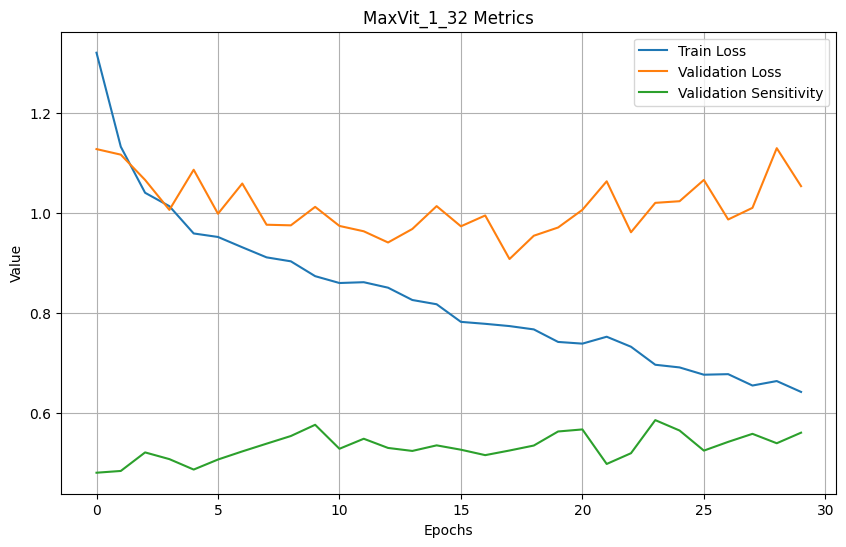

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("results/maxvit_layer_32.csv")
grouped_data = data.groupby('Model')

for model, model_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(model_data.index, model_data['train loss'], label='Train Loss')
    plt.plot(model_data.index, model_data['val loss'], label='Validation Loss')
    plt.plot(model_data.index, model_data['val sensitivity'], label='Validation Sensitivity')
    
    plt.title(f'{model} Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
